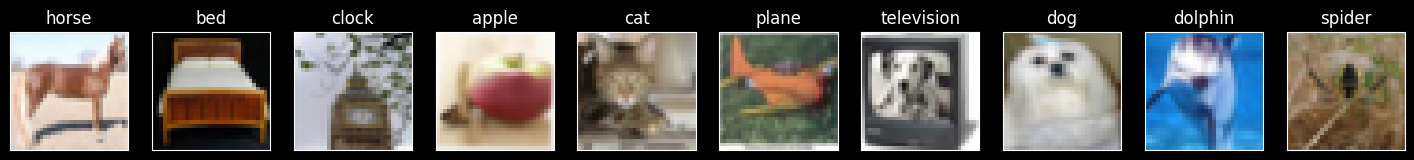

In [1]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
    # imshow, and set the interpolation mode to be "nearest"。
    fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
    # do not show the axes in the images.
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i+1)
    fig = no_axis_show(plt.imread(f'../../Data/ml2021spring-hw11/real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

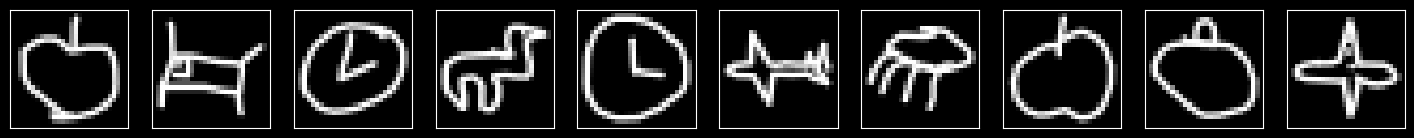

In [2]:
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i+1)
    fig = no_axis_show(plt.imread(f'../../Data/ml2021spring-hw11/real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

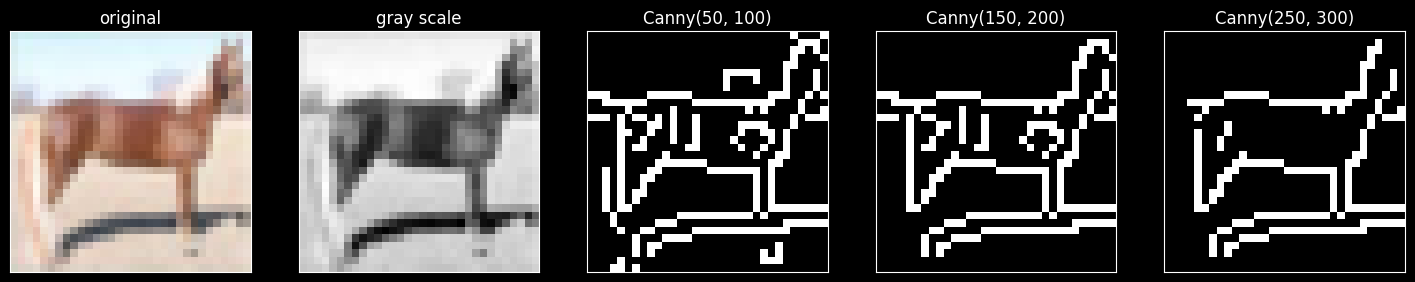

In [3]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'../../Data/ml2021spring-hw11/real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('../../Data/ml2021spring-hw11/real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('../../Data/ml2021spring-hw11/real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

In [5]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [6]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

In [7]:
from torch.utils.tensorboard import SummaryWriter
import datetime

# 初始化 TensorBoard Writer
def get_timestamp():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter(f'runs/domain_adaptation_{get_timestamp()}')

def train_epoch(source_dataloader, target_dataloader, lamb, epoch):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
        epoch: current epoch number (for logging)
    '''
    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        
        # 记录batch级别的指标
        if i % 10 == 0:  # 每10个batch记录一次
            writer.add_scalar('Batch/D_loss', loss.item(), epoch * len(source_dataloader) + i)
            writer.add_scalar('Batch/F_loss', loss.item(), epoch * len(source_dataloader) + i)
            batch_acc = torch.sum(torch.argmax(class_logits, dim=1) == source_label).item() / source_data.shape[0]
            writer.add_scalar('Batch/Accuracy', batch_acc, epoch * len(source_dataloader) + i)
        
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# train 200 epochs
for epoch in range(200):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1, epoch=epoch)
    
    # 记录epoch级别的指标
    writer.add_scalar('Epoch/D_loss', train_D_loss, epoch)
    writer.add_scalar('Epoch/F_loss', train_F_loss, epoch)
    writer.add_scalar('Epoch/Accuracy', train_acc, epoch)
    
    # 可选：记录模型参数分布
    if epoch % 10 == 0:
        for name, param in feature_extractor.named_parameters():
            writer.add_histogram(f'FeatureExtractor/{name}', param, epoch)
        for name, param in domain_classifier.named_parameters():
            writer.add_histogram(f'DomainClassifier/{name}', param, epoch)
        for name, param in label_predictor.named_parameters():
            writer.add_histogram(f'LabelPredictor/{name}', param, epoch)

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(
        epoch, train_D_loss, train_F_loss, train_acc))

writer.close()  # 确保关闭writer

epoch   0: train D loss: 0.6346, train F loss: 1.9217, acc 0.2584
epoch   1: train D loss: 0.6142, train F loss: 1.5845, acc 0.4118
epoch   2: train D loss: 0.5404, train F loss: 1.4241, acc 0.4778
epoch   3: train D loss: 0.5511, train F loss: 1.3589, acc 0.5106
epoch   4: train D loss: 0.5491, train F loss: 1.2981, acc 0.5286
epoch   5: train D loss: 0.5505, train F loss: 1.2480, acc 0.5496
epoch   6: train D loss: 0.5334, train F loss: 1.2002, acc 0.5608
epoch   7: train D loss: 0.5322, train F loss: 1.1800, acc 0.5752
epoch   8: train D loss: 0.5368, train F loss: 1.1347, acc 0.5842
epoch   9: train D loss: 0.5358, train F loss: 1.1115, acc 0.5908
epoch  10: train D loss: 0.5191, train F loss: 1.0629, acc 0.6150
epoch  11: train D loss: 0.5391, train F loss: 1.0457, acc 0.6136
epoch  12: train D loss: 0.5299, train F loss: 1.0187, acc 0.6266
epoch  13: train D loss: 0.5298, train F loss: 0.9562, acc 0.6514
epoch  14: train D loss: 0.5361, train F loss: 0.9282, acc 0.6578
epoch  15: